
# MYSQL 연동

In [24]:
import mysql.connector
from mysql.connector import connect,Error
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [25]:
warnings.filterwarnings(action='ignore')
#warnings.filterwarnings(action='default')

In [26]:
def create_mysql_connection(host, user, password, database):
    try:
        connection = connect(
            host = host,
            user = user,
            password = password,
            database = database
        )
        if connection.is_connected():
            print(f'Connected to MySQL server : {host}')
        return connection
    except Error as e:
        print(f'Error: {e}')
        return None

def close_connection(connection):
    if connection:
        connection.close()
        print('Connection to MYSQL closed.')

In [27]:
connection = create_mysql_connection('localhost', 'root', '579579', 'yammer')

Connected to MySQL server : localhost


In [ ]:
#close_connection(connection)

# Weekly Engagement by Device Category

In [6]:
wau_by_device_query = """
WITH period AS (
	SELECT pst_start, pst_end
	FROM rollup_periods
	WHERE period_id=1007 AND DATE_FORMAT(pst_start, '%Y-%m-%d')>='2014-04-25'
), events_device_type AS (
	SELECT *, (CASE WHEN device IN ('iphone 5','samsung galaxy s4','nexus 5','iphone 5s','iphone 4s','nokia lumia 635','htc one','samsung galaxy note','amazon fire phone') THEN 'phone'
					WHEN device IN ('ipad air','nexus 7','ipad mini','nexus 10','kindle fire','windows surface','samsumg galaxy tablet') THEN 'tablet'
                    ELSE 'computer' END) device_type
	FROM events
)

SELECT DATE_FORMAT(period.pst_start, '%Y-%m-%d') date, 
        COUNT(DISTINCT events_device_type.user_id) weekly_active_users,
        COUNT(DISTINCT IF(device_type='computer', events_device_type.user_id, NULL)) AS computer,
        COUNT(DISTINCT IF(device_type='phone', events_device_type.user_id, NULL)) AS phone,
        COUNT(DISTINCT IF(device_type='tablet', events_device_type.user_id, NULL)) AS tablet
FROM events_device_type INNER JOIN period ON (events_device_type.occurred_at BETWEEN pst_start AND pst_end)
						INNER JOIN users ON (events_device_type.user_id=users.user_id)
WHERE event_type='engagement' AND users.state='active'
GROUP BY period.pst_start
HAVING period.pst_start BETWEEN '2014-04-25' AND '2014-08-31'
   AND DAYOFWEEK(period.pst_start) = 2
"""
wau_by_device_df = pd.read_sql(wau_by_device_query, connection)
wau_by_device_df

,date,weekly_active_users,computer,phone,tablet
0,2014-04-28,701,415,281,111
1,2014-05-05,1054,712,461,187
2,2014-05-12,1094,715,481,197
3,2014-05-19,1147,758,526,190
4,2014-05-26,1113,716,500,182
5,2014-06-02,1173,791,505,208
6,2014-06-09,1219,798,545,209
7,2014-06-16,1263,813,541,238
8,2014-06-23,1249,834,526,222
9,2014-06-30,1271,805,578,230


<function matplotlib.pyplot.show(close=None, block=None)>

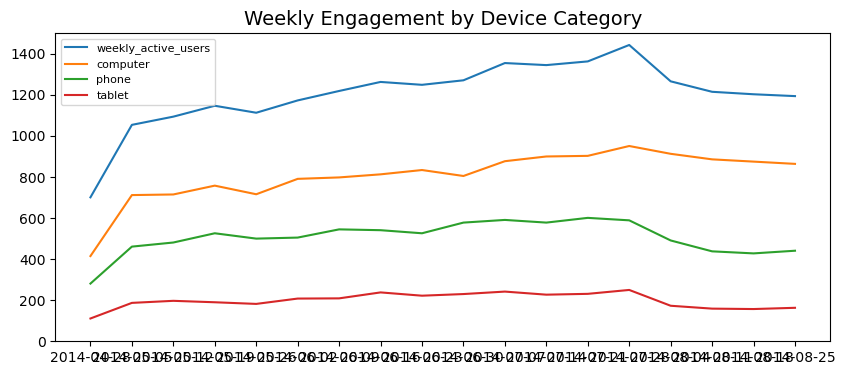

In [7]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()


ax.plot(wau_by_device_df.date, wau_by_device_df.weekly_active_users,label='weekly_active_users')
ax.plot(wau_by_device_df.date, wau_by_device_df.computer,label='computer')
ax.plot(wau_by_device_df.date, wau_by_device_df.phone,label='phone')
ax.plot(wau_by_device_df.date, wau_by_device_df.tablet,label='tablet')

ax.legend(fontsize=8)
plt.title('Weekly Engagement by Device Category',fontsize=14)
plt.ylim([0, 1500])

plt.show

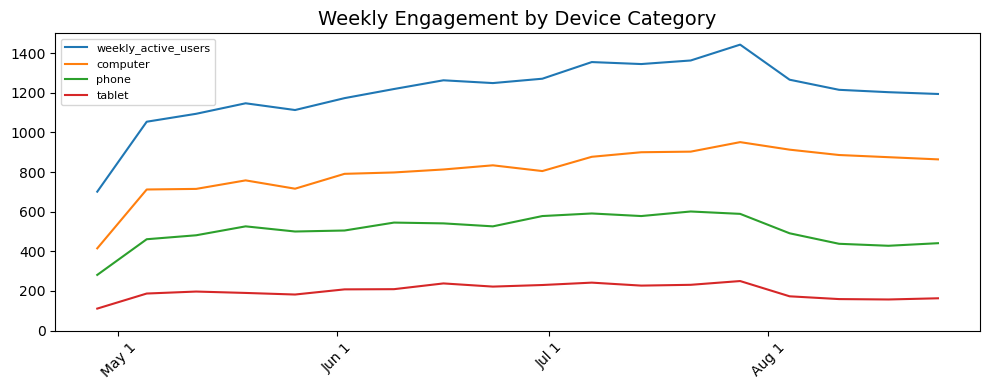

In [8]:
# 1) date를 확실하게 datetime으로
wau_by_device_df['date'] = pd.to_datetime(wau_by_device_df['date'])

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()

ax.plot(wau_by_device_df.date, wau_by_device_df.weekly_active_users, label='weekly_active_users')
ax.plot(wau_by_device_df.date, wau_by_device_df.computer, label='computer')
ax.plot(wau_by_device_df.date, wau_by_device_df.phone, label='phone')
ax.plot(wau_by_device_df.date, wau_by_device_df.tablet, label='tablet')

ax.legend(fontsize=8)
plt.title('Weekly Engagement by Device Category',fontsize=14)
plt.ylim([0, 1500])

# 2) x축 tick으로 쓸 "각 달의 1일" 생성
start = wau_by_device_df['date'].min().replace(day=1) + pd.DateOffset(months=1)  # 시작 달의 1일
end   = wau_by_device_df['date'].max().replace(day=1)  # 끝 달의 1일

# 매달 1일씩 (freq='MS' = Month Start)
monthly_ticks = pd.date_range(start=start, end=end, freq='MS')

# 3) 이걸 x축 tick으로 지정
ax.set_xticks(monthly_ticks)
ax.set_xticklabels([d.strftime('%b 1') for d in monthly_ticks], rotation=45)

plt.tight_layout()
plt.show()


# Weekly Active Users(WAU), WAU increase rate

In [9]:
wau_query = """
WITH period AS (
	SELECT pst_start, pst_end
	FROM rollup_periods
	WHERE period_id=1007 AND DATE_FORMAT(pst_start, '%Y-%m-%d')>='2014-04-25'
)

SELECT *, (weekly_active_users-LAG(weekly_active_users) OVER())/LAG(weekly_active_users) OVER()*100.0 WAU_increase_percent
FROM (
	SELECT DATE_FORMAT(period.pst_start, '%Y-%m-%d') date, 
			COUNT(DISTINCT events.user_id) weekly_active_users
	FROM events INNER JOIN period ON (events.occurred_at BETWEEN pst_start AND pst_end)
				INNER JOIN users ON (events.user_id=users.user_id)
	WHERE event_type='engagement' AND users.state='active'
	GROUP BY period.pst_start
	HAVING period.pst_start BETWEEN '2014-04-25' AND '2014-08-31'
	   AND DAYOFWEEK(period.pst_start) =2
) temp
"""
wau_query_df = pd.read_sql(wau_query, connection)
wau_query_df

,date,weekly_active_users,WAU_increase_percent
0,2014-04-28,701,NaN
1,2014-05-05,1054,50.35663
2,2014-05-12,1094,3.79507
3,2014-05-19,1147,4.84461
4,2014-05-26,1113,-2.96425
5,2014-06-02,1173,5.39084
6,2014-06-09,1219,3.92157
7,2014-06-16,1263,3.60952
8,2014-06-23,1249,-1.10847
9,2014-06-30,1271,1.76141


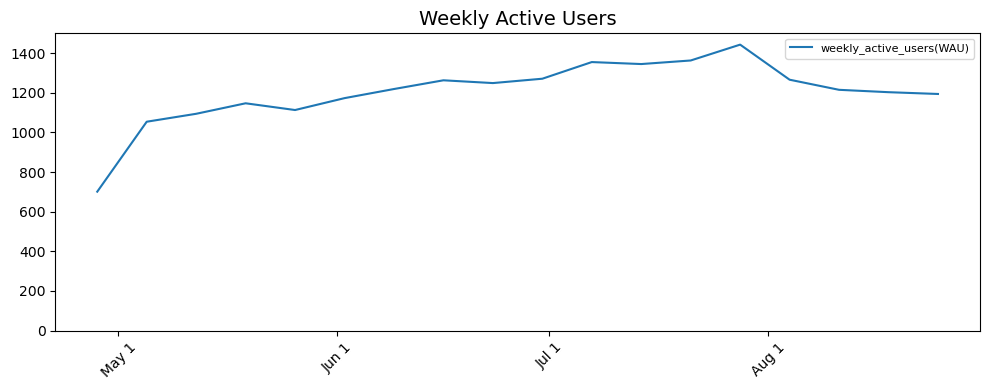

<function matplotlib.pyplot.show(close=None, block=None)>

In [10]:
# 1) date를 확실하게 datetime으로
wau_query_df['date'] = pd.to_datetime(wau_query_df['date'])

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()

ax.plot(wau_query_df.date, wau_query_df.weekly_active_users,label='weekly_active_users(WAU)')

ax.legend(fontsize=8)
plt.title('Weekly Active Users',fontsize=14)
plt.ylim([0, 1500])

# 2) x축 tick으로 쓸 "각 달의 1일" 생성
start = wau_query_df['date'].min().replace(day=1) + pd.DateOffset(months=1)  # 시작 달의 1일
end   = wau_query_df['date'].max().replace(day=1)  # 끝 달의 1일

# 매달 1일씩 (freq='MS' = Month Start)
monthly_ticks = pd.date_range(start=start, end=end, freq='MS')

# 3) 이걸 x축 tick으로 지정
ax.set_xticks(monthly_ticks)
ax.set_xticklabels([d.strftime('%b 1') for d in monthly_ticks], rotation=45)

plt.tight_layout()
plt.show()

plt.show

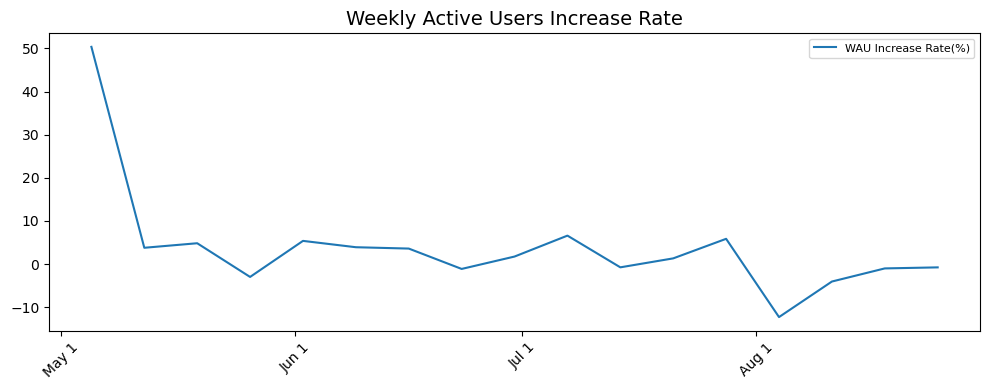

<function matplotlib.pyplot.show(close=None, block=None)>

In [11]:
# 1) date를 확실하게 datetime으로
wau_query_df['date'] = pd.to_datetime(wau_query_df['date'])

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()

ax.plot(wau_query_df.date, wau_query_df.WAU_increase_percent,label='WAU Increase Rate(%)')

ax.legend(fontsize=8)
plt.title('Weekly Active Users Increase Rate',fontsize=14)

# 2) x축 tick으로 쓸 "각 달의 1일" 생성
start = wau_query_df['date'].min().replace(day=1) + pd.DateOffset(months=1)  # 시작 달의 1일
end   = wau_query_df['date'].max().replace(day=1)  # 끝 달의 1일

# 매달 1일씩 (freq='MS' = Month Start)
monthly_ticks = pd.date_range(start=start, end=end, freq='MS')

# 3) 이걸 x축 tick으로 지정
ax.set_xticks(monthly_ticks)
ax.set_xticklabels([d.strftime('%b 1') for d in monthly_ticks], rotation=45)

plt.tight_layout()
plt.show()

plt.show


# Check for Growth
### Daily Signups

In [12]:
growth_all_users_query = """
SELECT STR_TO_DATE(DATE_FORMAT(created_at,'%Y-%m-%d'),'%Y-%m-%d') date, COUNT(user_id) all_users
FROM users
WHERE (DATE_FORMAT(created_at,'%Y-%m-%d') BETWEEN '2014-06-01' AND '2014-08-31')
GROUP BY STR_TO_DATE(DATE_FORMAT(created_at,'%Y-%m-%d'),'%Y-%m-%d')
"""

growth_all_users_query_df = pd.read_sql(growth_all_users_query, connection)
growth_all_users_query_df

,date,all_users
0,2014-06-01,23
1,2014-06-02,69
2,2014-06-03,63
3,2014-06-04,71
4,2014-06-05,76
...,...,...
87,2014-08-27,90
88,2014-08-28,95
89,2014-08-29,97
90,2014-08-30,26


In [13]:
growth_active_users_query = """
SELECT STR_TO_DATE(DATE_FORMAT(created_at,'%Y-%m-%d'),'%Y-%m-%d') date, COUNT(user_id) active_users
FROM users
WHERE (DATE_FORMAT(created_at,'%Y-%m-%d') BETWEEN '2014-06-01' AND '2014-08-31') AND (DATE_FORMAT(activated_at,'%Y-%m-%d') BETWEEN '2014-06-01' AND '2014-08-31')
GROUP BY STR_TO_DATE(DATE_FORMAT(created_at,'%Y-%m-%d'),'%Y-%m-%d')
"""

growth_active_users_query_df = pd.read_sql(growth_active_users_query, connection)
growth_active_users_query_df

,date,active_users
0,2014-06-01,11
1,2014-06-02,33
2,2014-06-03,29
3,2014-06-04,44
4,2014-06-05,32
...,...,...
87,2014-08-27,48
88,2014-08-28,50
89,2014-08-29,45
90,2014-08-30,12


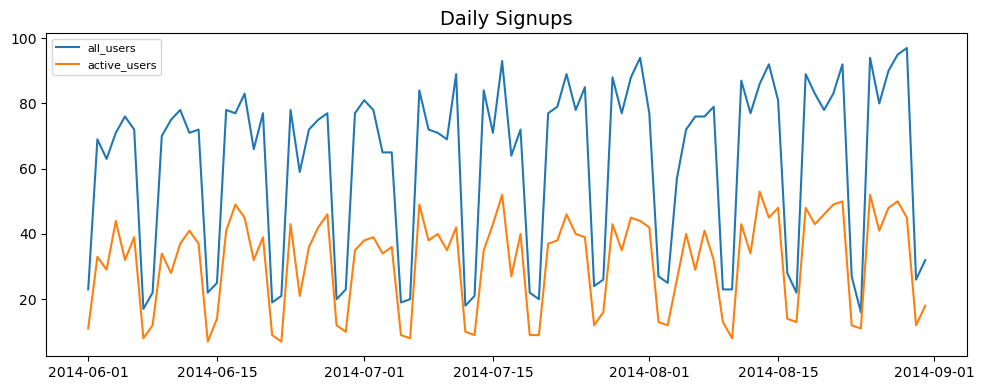

In [14]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()

ax.plot(growth_all_users_query_df.date, growth_all_users_query_df.all_users, label='all_users')
ax.plot(growth_active_users_query_df.date, growth_active_users_query_df.active_users, label='active_users')
ax.legend(fontsize=8)
plt.title('Daily Signups',fontsize=14)

plt.tight_layout()
plt.show()

# Check for Retention
### Engagement by User Age Cohort

In [15]:
retention_wau_by_age_query = """
SELECT DATE_FORMAT(engagement_date_start, '%Y-%m-%d') engagement_date_start, age, COUNT(DISTINCT user_id) engagement_active_user_cnt
FROM (
	SELECT users.user_id user_id, users.created_at signup_date, events.occurred_at engagement_date, DATE_SUB(events.occurred_at, INTERVAL WEEKDAY(events.occurred_at) DAY) engagement_date_start,
		(CASE WHEN DATEDIFF('2014-09-01', users.created_at)>=70 THEN '10+ weeks'
			 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 63 AND 69 THEN '9 weeks'
			 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 56 AND 62 THEN '8 weeks'
			 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 49 AND 55 THEN '7 weeks'
			 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 42 AND 48 THEN '6 weeks'
			 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 35 AND 41 THEN '5 weeks'
			 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 28 AND 34 THEN '4 weeks'
			 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 21 AND 27 THEN '3 weeks'
			 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 14 AND 20 THEN '2 weeks'
			 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 7 AND 13 THEN '1 weeks'
			 ELSE 'less than a week'
			 END) age
	FROM events INNER JOIN users ON (events.user_id=users.user_id)
	WHERE events.event_type='engagement' AND events.event_name='login' AND 
			events.occurred_at>=STR_TO_DATE('2014-05-01', '%Y-%m-%d') AND events.occurred_at<STR_TO_DATE('2014-09-01', '%Y-%m-%d') AND
            users.state='active'
) temp
GROUP BY DATE_FORMAT(engagement_date_start, '%Y-%m-%d'), age
ORDER BY DATE_FORMAT(engagement_date_start, '%Y-%m-%d')
"""

retention_wau_by_age_df = pd.read_sql(retention_wau_by_age_query, connection)
retention_wau_by_age_df

,engagement_date_start,age,engagement_active_user_cnt
0,2014-04-28,10+ weeks,701
1,2014-05-05,10+ weeks,1054
2,2014-05-12,10+ weeks,1094
3,2014-05-19,10+ weeks,1147
4,2014-05-26,10+ weeks,1113
...,...,...,...
68,2014-08-25,6 weeks,24
69,2014-08-25,7 weeks,19
70,2014-08-25,8 weeks,19
71,2014-08-25,9 weeks,17


In [30]:
mysql_pivot_query = """
WITH test AS(
	SELECT DATE_FORMAT(engagement_date_start, '%Y-%m-%d') engagement_date_start, age, COUNT(DISTINCT user_id) engagement_active_user_cnt
	FROM (
		SELECT users.user_id user_id, users.created_at signup_date, events.occurred_at engagement_date, DATE_SUB(events.occurred_at, INTERVAL WEEKDAY(events.occurred_at) DAY) engagement_date_start,
			(CASE WHEN DATEDIFF('2014-09-01', users.created_at)>=70 THEN '10+ weeks'
				 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 63 AND 69 THEN '9 weeks'
				 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 56 AND 62 THEN '8 weeks'
				 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 49 AND 55 THEN '7 weeks'
				 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 42 AND 48 THEN '6 weeks'
				 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 35 AND 41 THEN '5 weeks'
				 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 28 AND 34 THEN '4 weeks'
				 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 21 AND 27 THEN '3 weeks'
				 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 14 AND 20 THEN '2 weeks'
				 WHEN DATEDIFF('2014-09-01', users.created_at) BETWEEN 7 AND 13 THEN '1 weeks'
				 ELSE 'less than a week'
				 END) age
		FROM events INNER JOIN users ON (events.user_id=users.user_id)
		WHERE events.event_type='engagement' AND events.event_name='login' AND 
				events.occurred_at>=STR_TO_DATE('2014-05-01', '%Y-%m-%d') AND events.occurred_at<STR_TO_DATE('2014-09-01', '%Y-%m-%d') AND
				users.state='active'
	) temp
	GROUP BY DATE_FORMAT(engagement_date_start, '%Y-%m-%d'), age
	ORDER BY DATE_FORMAT(engagement_date_start, '%Y-%m-%d')
)

SELECT engagement_date_start,
		MAX(IF(age='10+ weeks', engagement_active_user_cnt,NULL)) '10+ weeks',
        MAX(IF(age='9 weeks', engagement_active_user_cnt,NULL)) '9 weeks',
        MAX(IF(age='8 weeks', engagement_active_user_cnt,NULL)) '8 weeks',
        MAX(IF(age='7 weeks', engagement_active_user_cnt,NULL)) '7 weeks',
        MAX(IF(age='6 weeks', engagement_active_user_cnt,NULL)) '6 weeks',
        MAX(IF(age='5 weeks', engagement_active_user_cnt,NULL)) '5 weeks',
        MAX(IF(age='4 weeks', engagement_active_user_cnt,NULL)) '4 weeks',
        MAX(IF(age='3 weeks', engagement_active_user_cnt,NULL)) '3 weeks',
        MAX(IF(age='2 weeks', engagement_active_user_cnt,NULL)) '2 weeks',
        MAX(IF(age='1 weeks', engagement_active_user_cnt,NULL)) '1 weeks',
        MAX(IF(age='less than a week', engagement_active_user_cnt,NULL)) 'less than a week'
FROM test
GROUP BY engagement_date_start
"""

mysql_pivot_df = pd.read_sql(mysql_pivot_query, connection)
mysql_pivot_df

,engagement_date_start,10+ weeks,9 weeks,8 weeks,7 weeks,6 weeks,5 weeks,4 weeks,3 weeks,2 weeks,1 weeks,less than a week
0,2014-04-28,701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-05-05,1054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-05-12,1094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-05-19,1147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-05-26,1113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014-06-02,1173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014-06-09,1219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014-06-16,1262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014-06-23,1082,167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2014-06-30,954,153.0,164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
python_pivot_df = retention_wau_by_age_df.pivot(index='engagement_date_start', columns='age', values='engagement_active_user_cnt')
python_pivot_df = python_pivot_df[['10+ weeks', '9 weeks', '8 weeks', '7 weeks', '6 weeks', '5 weeks', '4 weeks', '3 weeks', '2 weeks', '1 weeks', 'less than a week']]

python_pivot_df

age,10+ weeks,9 weeks,8 weeks,7 weeks,6 weeks,5 weeks,4 weeks,3 weeks,2 weeks,1 weeks,less than a week
engagement_date_start,,,,,,,,,,,
2014-04-28,701.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-05,1054.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-12,1094.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-19,1147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-26,1113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-02,1173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-09,1219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-16,1262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-23,1082.0,167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


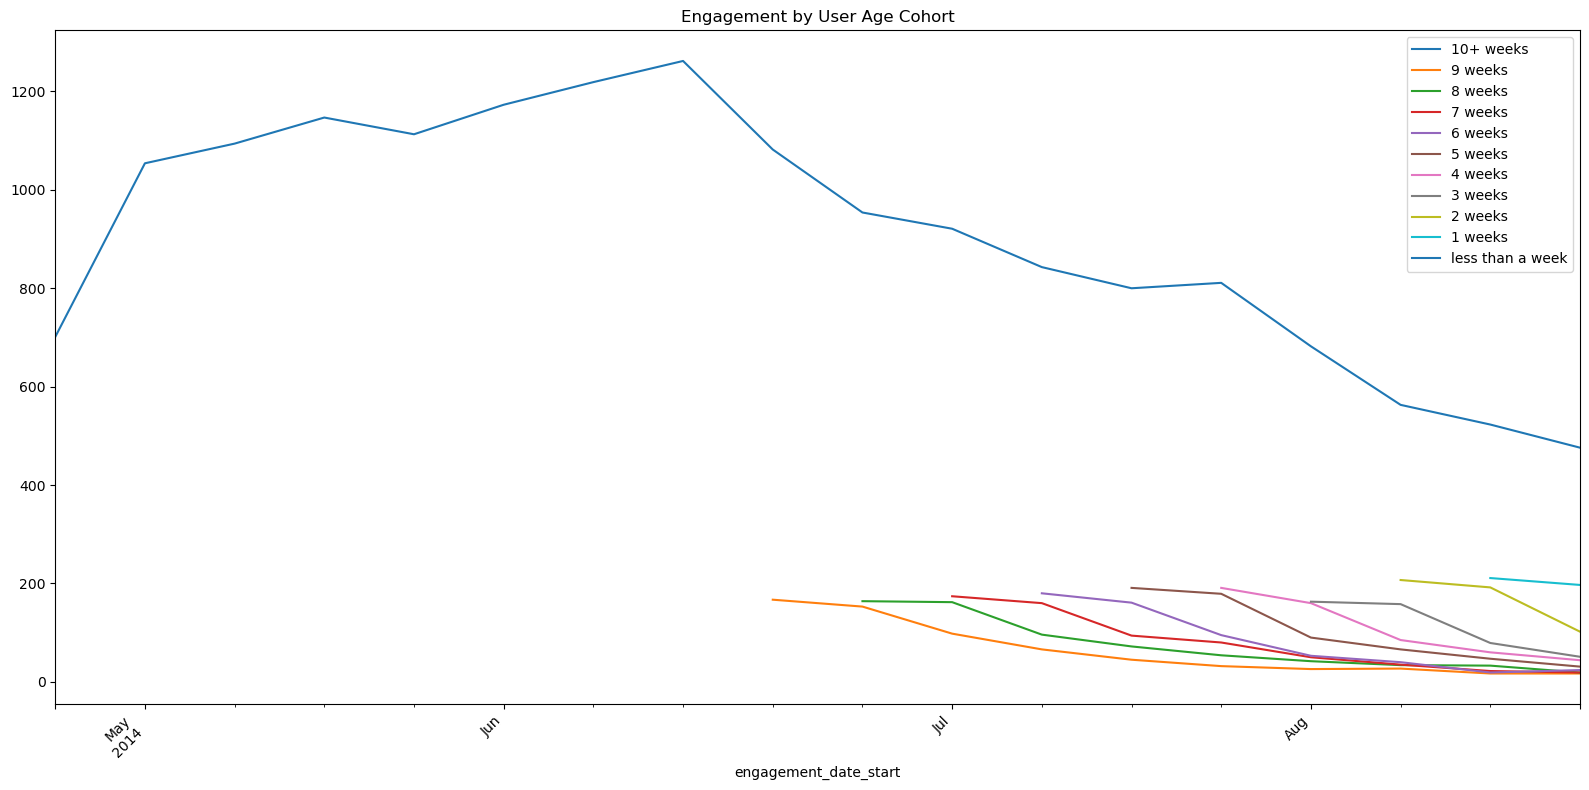

In [32]:
mysql_pivot_df["engagement_date_start"] = pd.to_datetime(mysql_pivot_df["engagement_date_start"])
mysql_pivot_df = mysql_pivot_df.sort_values("engagement_date_start").set_index("engagement_date_start")

ax = mysql_pivot_df.plot(figsize=(16, 8))
plt.xticks(rotation=45, ha="right")
plt.title("Engagement by User Age Cohort")
plt.tight_layout()
plt.show()

# Retention Analysis (1)
### WAU Increase Rate by Device

In [17]:
wau_device_query = """
WITH period AS (
	SELECT pst_start, pst_end
	FROM rollup_periods
	WHERE period_id=1007 AND DATE_FORMAT(pst_start, '%Y-%m-%d')>='2014-04-25'
), events_device_type AS (
	SELECT *, (CASE WHEN device IN ('iphone 5','samsung galaxy s4','nexus 5','iphone 5s','iphone 4s','nokia lumia 635','htc one','samsung galaxy note','amazon fire phone') THEN 'phone'
					WHEN device IN ('ipad air','nexus 7','ipad mini','nexus 10','kindle fire','windows surface','samsumg galaxy tablet') THEN 'tablet'
                    ELSE 'computer' END) device_type
	FROM events
)

SELECT *, (weekly_active_users-LAG(weekly_active_users) OVER())/LAG(weekly_active_users) OVER()*100.0 WAU_increase_percent,
		(computer-LAG(computer) OVER())/LAG(computer) OVER()*100.0 WAU_computer_increase_percent,
        (phone-LAG(phone) OVER())/LAG(phone) OVER()*100.0 WAU_phone_increase_percent,
        (tablet-LAG(tablet) OVER())/LAG(tablet) OVER()*100.0 WAU_tablet_increase_percent
FROM (
	SELECT DATE_FORMAT(period.pst_start, '%Y-%m-%d') date, 
			COUNT(DISTINCT events_device_type.user_id) weekly_active_users,
			COUNT(DISTINCT IF(device_type='computer', events_device_type.user_id, NULL)) AS computer,
			COUNT(DISTINCT IF(device_type='phone', events_device_type.user_id, NULL)) AS phone,
			COUNT(DISTINCT IF(device_type='tablet', events_device_type.user_id, NULL)) AS tablet
	FROM events_device_type INNER JOIN period ON (events_device_type.occurred_at BETWEEN pst_start AND pst_end)
				INNER JOIN users ON (events_device_type.user_id=users.user_id)
	WHERE event_type='engagement' AND users.state='active'
	GROUP BY period.pst_start
	HAVING period.pst_start BETWEEN '2014-04-25' AND '2014-08-31'
	   AND DAYOFWEEK(period.pst_start) =2
) temp
"""

wau_device_df = pd.read_sql(wau_device_query, connection)
wau_device_df

,date,weekly_active_users,computer,phone,tablet,WAU_increase_percent,WAU_computer_increase_percent,WAU_phone_increase_percent,WAU_tablet_increase_percent
0,2014-04-28,701,415,281,111,NaN,NaN,NaN,NaN
1,2014-05-05,1054,712,461,187,50.35663,71.56627,64.05694,68.46847
2,2014-05-12,1094,715,481,197,3.79507,0.42135,4.33839,5.34759
3,2014-05-19,1147,758,526,190,4.84461,6.01399,9.35551,-3.55330
4,2014-05-26,1113,716,500,182,-2.96425,-5.54090,-4.94297,-4.21053
5,2014-06-02,1173,791,505,208,5.39084,10.47486,1.00000,14.28571
6,2014-06-09,1219,798,545,209,3.92157,0.88496,7.92079,0.48077
7,2014-06-16,1263,813,541,238,3.60952,1.87970,-0.73394,13.87560
8,2014-06-23,1249,834,526,222,-1.10847,2.58303,-2.77264,-6.72269
9,2014-06-30,1271,805,578,230,1.76141,-3.47722,9.88593,3.60360


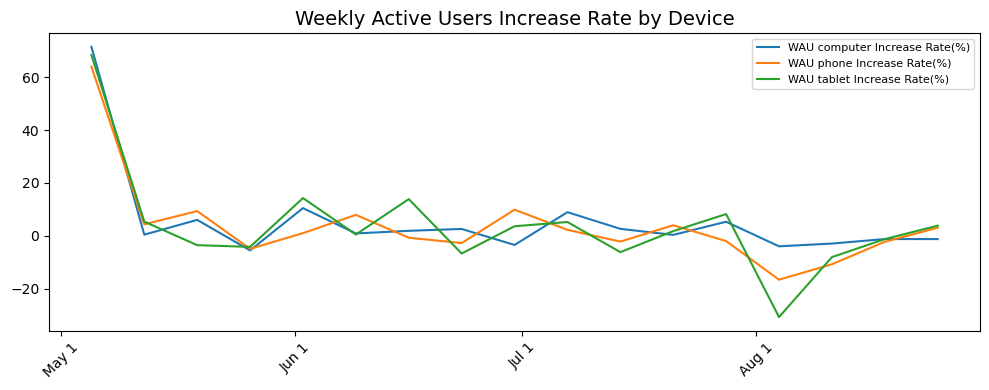

<function matplotlib.pyplot.show(close=None, block=None)>

In [18]:
# 1) date를 확실하게 datetime으로
wau_device_df['date'] = pd.to_datetime(wau_device_df['date'])

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()

ax.plot(wau_device_df.date, wau_device_df.WAU_computer_increase_percent,label='WAU computer Increase Rate(%)')
ax.plot(wau_device_df.date, wau_device_df.WAU_phone_increase_percent,label='WAU phone Increase Rate(%)')
ax.plot(wau_device_df.date, wau_device_df.WAU_tablet_increase_percent,label='WAU tablet Increase Rate(%)')

ax.legend(fontsize=8)
plt.title('Weekly Active Users Increase Rate by Device',fontsize=14)

# 2) x축 tick으로 쓸 "각 달의 1일" 생성
start = wau_query_df['date'].min().replace(day=1) + pd.DateOffset(months=1)  # 시작 달의 1일
end   = wau_query_df['date'].max().replace(day=1)  # 끝 달의 1일

# 매달 1일씩 (freq='MS' = Month Start)
monthly_ticks = pd.date_range(start=start, end=end, freq='MS')

# 3) 이걸 x축 tick으로 지정
ax.set_xticks(monthly_ticks)
ax.set_xticklabels([d.strftime('%b 1') for d in monthly_ticks], rotation=45)

plt.tight_layout()
plt.show()

plt.show

# Retention Analysis (2)
### Emails

In [19]:
emails_query = """
SELECT DATE_FORMAT(DATE_SUB(occurred_at, INTERVAL WEEKDAY(occurred_at) DAY), '%Y-%m-%d') weekstart, action,
		COUNT(DISTINCT user_id) users_cnt
FROM emails
GROUP BY DATE_FORMAT(DATE_SUB(occurred_at, INTERVAL WEEKDAY(occurred_at) DAY), '%Y-%m-%d'), action
ORDER BY weekstart, action DESC
"""

emails_df = pd.read_sql(emails_query, connection)
emails_df

,weekstart,action,users_cnt
0,2014-04-28,sent_weekly_digest,908
1,2014-04-28,sent_reengagement_email,98
2,2014-04-28,email_open,332
3,2014-04-28,email_clickthrough,187
4,2014-05-05,sent_weekly_digest,2602
...,...,...,...
67,2014-08-18,email_clickthrough,487
68,2014-08-25,sent_weekly_digest,4111
69,2014-08-25,sent_reengagement_email,263
70,2014-08-25,email_open,1511


In [21]:
emails_pivot_df = emails_df.pivot(index='weekstart', columns='action', values='users_cnt')
emails_pivot_df = emails_pivot_df[['sent_weekly_digest', 'sent_reengagement_email', 'email_open', 'email_clickthrough']]

emails_pivot_df

action,sent_weekly_digest,sent_reengagement_email,email_open,email_clickthrough
weekstart,,,,
2014-04-28,908,98,332,187
2014-05-05,2602,164,910,431
2014-05-12,2665,175,961,478
2014-05-19,2733,179,984,495
2014-05-26,2822,179,1008,447
2014-06-02,2911,199,972,483
2014-06-09,3003,190,1058,527
2014-06-16,3105,234,1144,558
2014-06-23,3207,187,1080,517


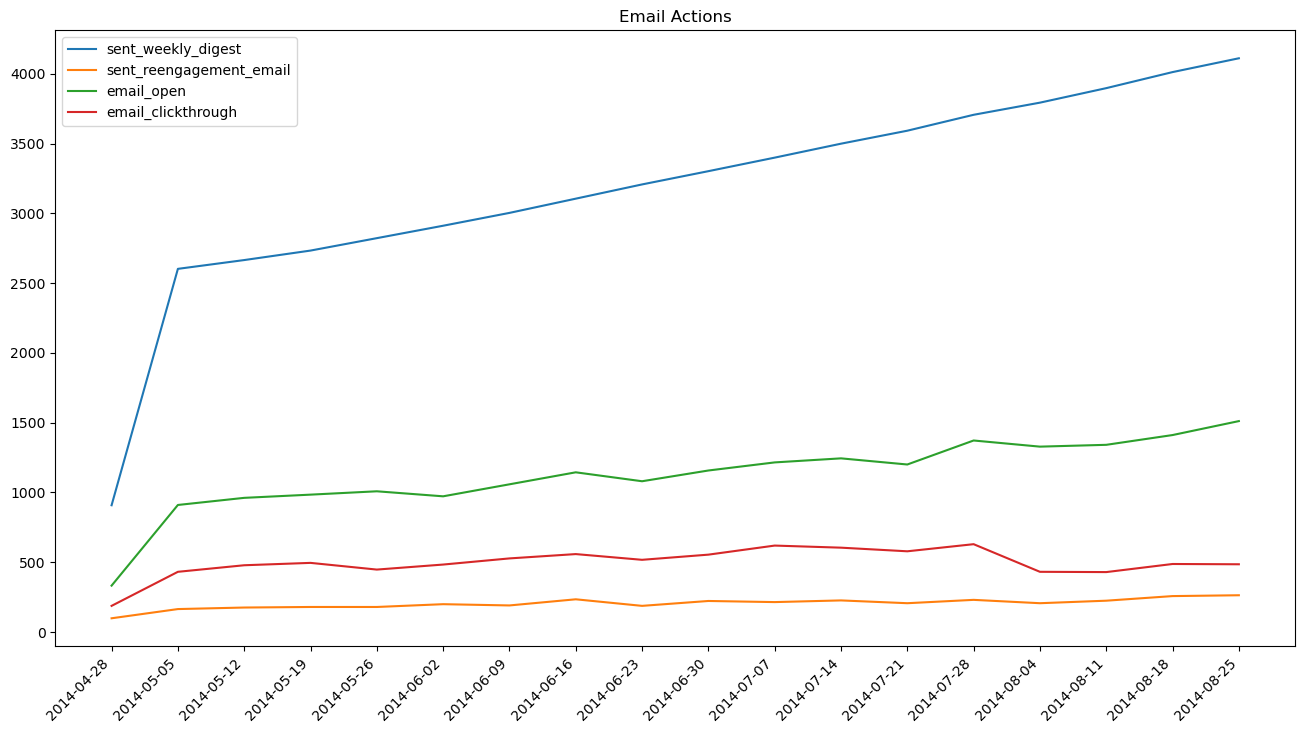

In [26]:
plt.figure(figsize=(16, 8))
plt.plot(emails_pivot_df, label=emails_pivot_df.columns)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.title('Email Actions')
plt.show()

# Retention Analysis (3)
### Clickthrough

In [43]:
emails_reacts_query = """
SELECT 
		STR_TO_DATE(weekstart, '%Y-%m-%d') weekstart, 
		#SUM(CASE WHEN action1='sent_weekly_digest' THEN 1 ELSE 0 END) sent_weekly_digest_all,
        #SUM(CASE WHEN action1='sent_weekly_digest' AND action2='email_clickthrough' THEN 1 ELSE 0 END) sent_weekly_digest_ct,
        (SUM(CASE WHEN action1='sent_weekly_digest' AND action2='email_clickthrough' THEN 1 ELSE 0 END))/(SUM(CASE WHEN action1='sent_weekly_digest' THEN 1 ELSE 0 END))*100.0 weekly_ctr,
        #SUM(CASE WHEN action1='sent_weekly_digest' AND action3='email_open' THEN 1 ELSE 0 END) sent_weekly_digest_opr,
        (SUM(CASE WHEN action1='sent_weekly_digest' AND action3='email_open' THEN 1 ELSE 0 END))/(SUM(CASE WHEN action1='sent_weekly_digest' THEN 1 ELSE 0 END))*100.0 weekly_open_rate,
        #SUM(CASE WHEN action1='sent_reengagement_email' THEN 1 ELSE 0 END) sent_retain_all,
        #SUM(CASE WHEN action1='sent_reengagement_email' AND action2='email_clickthrough' THEN 1 ELSE 0 END) sent_retain_ct,
        (SUM(CASE WHEN action1='sent_reengagement_email' AND action2='email_clickthrough' THEN 1 ELSE 0 END))/(SUM(CASE WHEN action1='sent_reengagement_email' THEN 1 ELSE 0 END))*100.0 retain_ctr,
        #SUM(CASE WHEN action1='sent_reengagement_email' AND action3='email_open' THEN 1 ELSE 0 END) sent_retain_opr,
        (SUM(CASE WHEN action1='sent_reengagement_email' AND action3='email_open' THEN 1 ELSE 0 END))/(SUM(CASE WHEN action1='sent_reengagement_email' THEN 1 ELSE 0 END))*100.0 retain_open_rate
FROM (
	SELECT e1.user_id user_id, e1.occurred_at occured_at1, e1.action action1, e2.occurred_at occurred_at2, e2.action action2, e3.occurred_at occurred_at3, e3.action action3, DATE_FORMAT((DATE_SUB(e1.occurred_at, INTERVAL WEEKDAY(e1.occurred_at) DAY)), '%Y-%m-%d') weekstart
	FROM emails e1 LEFT JOIN emails e2 ON (e1.occurred_at < e2.occurred_at AND 
											e2.occurred_at < DATE_ADD(e1.occurred_at, INTERVAL 5 MINUTE) AND
											e1.user_id = e2.user_id AND 
											(e2.action='email_clickthrough'))
					LEFT JOIN emails e3 ON (e1.occurred_at < e3.occurred_at AND
											e3.occurred_at < DATE_ADD(e1.occurred_at, INTERVAL 5 MINUTE) AND
											e1.user_id = e3.user_id AND
											(e3.action='email_open'))
	WHERE DATE_FORMAT(e1.occurred_at, '%Y-%m-%d')>='2014-05-01' AND DATE_FORMAT(e1.occurred_at, '%Y-%m-%d')<'2014-09-01' AND
			e1.action='sent_weekly_digest' OR e1.action='sent_reengagement_email'
) emails_reacts
GROUP BY STR_TO_DATE(weekstart, '%Y-%m-%d')
"""
emails_reacts_df = pd.read_sql(emails_reacts_query, connection)
emails_reacts_df

,weekstart,weekly_ctr,weekly_open_rate,retain_ctr,retain_open_rate
0,2014-05-12,12.45779,30.35647,84.00000,92.57143
1,2014-05-19,12.73326,30.51592,83.79888,89.94413
2,2014-06-23,11.59963,28.90552,81.28342,87.16578
3,2014-06-30,11.47789,29.28528,81.08108,90.54054
4,2014-07-28,12.03454,31.84026,81.30435,89.56522
5,2014-06-16,12.07729,30.62802,80.34188,89.74359
6,2014-06-02,11.74854,28.16901,75.37688,86.93467
7,2014-07-07,13.26861,30.53839,79.90654,89.71963
8,2014-08-18,6.87936,29.81057,82.10117,87.54864
9,2014-05-05,11.76018,29.82321,78.04878,87.19512


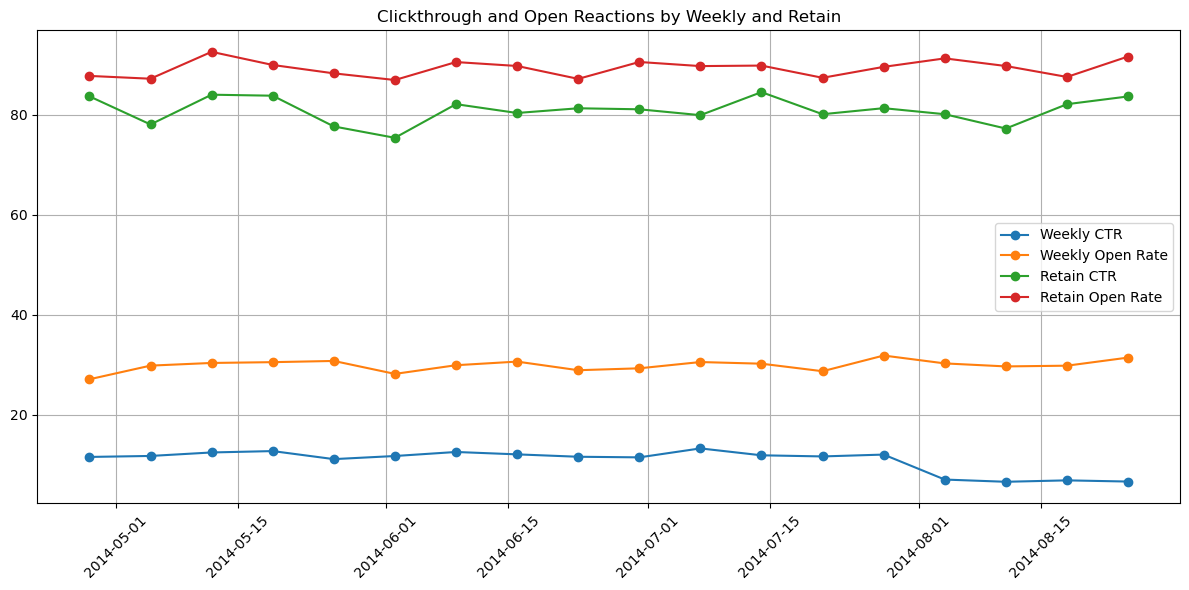

In [47]:
# 날짜 변환 & 정렬
emails_reacts_df['weekstart'] = pd.to_datetime(emails_reacts_df['weekstart'])
emails_reacts_df = emails_reacts_df.sort_values('weekstart')

plt.figure(figsize=(12, 6))

plt.plot(emails_reacts_df['weekstart'], emails_reacts_df['weekly_ctr'], marker='o', label='Weekly CTR')
plt.plot(emails_reacts_df['weekstart'], emails_reacts_df['weekly_open_rate'], marker='o', label='Weekly Open Rate')
plt.plot(emails_reacts_df['weekstart'], emails_reacts_df['retain_ctr'], marker='o', label='Retain CTR')
plt.plot(emails_reacts_df['weekstart'], emails_reacts_df['retain_open_rate'], marker='o', label='Retain Open Rate')

#plt.xlabel('Week Start')
#plt.ylabel('Rate (%)')
plt.title('Clickthrough and Open Reactions by Weekly and Retain')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)  # x축 날짜 기울여서 보기 좋게

plt.tight_layout()
plt.show()